## Data Import and Preprocessing

In [5]:
import os
import datetime
import warnings

import pandas as pd
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import plotly.express as px
import plotly.io as pio
import kmapper as km
import plotly.graph_objects as go
from kmapper.plotlyviz import plotlyviz

from bs4 import BeautifulSoup
import matplotlib.colors as mcolors

from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding
import umap.umap_ as umap

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, PowerTransformer, MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import BayesianRidge
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.cluster import DBSCAN

from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive

In [6]:
with open('RT_IOT2022', mode = 'r') as f:
    iot_df = []
    lines = f.readlines()
    cols =lines[0].strip().split(',')
    cols[0] = 'ID'
    
    for line in lines[1:]:
        iot_df.append(line.strip().split(','))

iot_df = pd.DataFrame(iot_df, columns = cols)


In [7]:
iot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123117 entries, 0 to 123116
Data columns (total 85 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   ID                        123117 non-null  object
 1   id.orig_p                 123117 non-null  object
 2   id.resp_p                 123117 non-null  object
 3   proto                     123117 non-null  object
 4   service                   123117 non-null  object
 5   flow_duration             123117 non-null  object
 6   fwd_pkts_tot              123117 non-null  object
 7   bwd_pkts_tot              123117 non-null  object
 8   fwd_data_pkts_tot         123117 non-null  object
 9   bwd_data_pkts_tot         123117 non-null  object
 10  fwd_pkts_per_sec          123117 non-null  object
 11  bwd_pkts_per_sec          123117 non-null  object
 12  flow_pkts_per_sec         123117 non-null  object
 13  down_up_ratio             123117 non-null  object
 14  fwd_

In [8]:
# Supplementary data import
local_file = True
save_locally = True

full_dataset = ['BenignTraffic.pcap_Flow']
random_sample_size = 10000

include_dir = None
include_files = None
drive_folder_id = '1sPl6Pu8M2KNwefJHdm6NfJ5fnatzbDjf'
dataset_folder = os.path.join(os.getcwd(), 'CIC IoT-IDAD Dataset 2024')

def list_files_in_directory(directory, file_extension, include_dir = None, exclude_dir = None, include_files = None):

    dir_tree = list(os.walk(directory))
    
    if include_dir is None:
        include_dir = [root.split('/')[-1] for root, dir_, file in dir_tree]

    if not isinstance(include_dir, list):
        include_dir = [include_dir]

    if not isinstance(exclude_dir, list):
        exclude_dir = [exclude_dir]

    if include_files is None:
        include_files = [file for root, dir_, file in dir_tree]
        include_files = [file for item in include_files for file in (item if isinstance(item, list) else [item])]

    if not isinstance(include_files, list):
        include_files = [include_files]
        
    data_files = []
    include_dir = set(include_dir).difference(set(exclude_dir))
    
    for root, dirs, files in dir_tree:
        if root.split('/')[-1] in include_dir:
            for file in files:
                if file.lower().endswith(file_extension.lower()) and file in include_files:
                    file_path = os.path.join(root, file)
                    data_files.append((file.replace(file_extension, '').translate(str.maketrans('', '', '0123456789')), file_path))

    return data_files

if local_file:

    data_files = list_files_in_directory(dataset_folder, '.csv', exclude_dir = 'Device Identification', include_dir = include_dir)
    file_count = 0

    for name, file in data_files:

        if file_count == 0:
            iot_df2 = pd.read_csv(file)
            if name not in full_dataset:
                iot_df2 = iot_df2.sample(min(iot_df2.shape[0], random_sample_size), replace = False)
            iot_df2.loc[:, 'Label'] = name
        else:
            iot_df2_t = pd.read_csv(file)
            if name not in full_dataset:
                iot_df2_t = iot_df2_t.sample(min(iot_df2_t.shape[0], random_sample_size), replace = False)
            iot_df2_t.loc[:, 'Label'] = name
            iot_df2 = pd.concat([iot_df2, iot_df2_t], axis = 0, ignore_index = True)
            
        file_count += 1
    
else:

    # Authenticate
    gauth = GoogleAuth()
    gauth.LoadClientConfigFile('client_secret_877315538591-lf4e137q655jcdvdpvmk3r3nt99co4ld.apps.googleusercontent.com.json')
    gauth.CommandLineAuth()
    drive = GoogleDrive(gauth)

    def gdrive_list_all_subfolders(drive_folder_id):
        
        query = f"'{drive_folder_id}' in parents and mimeType='application/vnd.google-apps.folder' and trashed=false"
        folder_list = drive.ListFile({'q': query}).GetList()
        all_folder_ids = [drive_folder_id] + [f['id'] for f in folder_list]
    
        # Recursively find subfolders
        for folder in folder_list:
            all_folder_ids.extend(gdrive_list_all_subfolders(folder['id']))
            
        return all_folder_ids

    folder_ids = gdrive_list_all_subfolders(folder_id)
    folder_conditions = " or ".join([f"'{fid}' in parents" for fid in folder_ids])
    query = f"({folder_conditions}) and mimeType='text/csv' and trashed=false"
    file_list = drive.ListFile({'q': query}).GetList()

    if include_files is None:
        include_dir = [dfile['title'] for dfile in file_list]

    if not isinstance(include_files, list):
        include_files = [include_files]
        
    file_count = 0
    
    for dfile in file_list:

        if dfile in include_dir:
            
            file = drive.CreateFile({'id': dfile['id']})
        
            if save_locally:
    
                folder = drive.CreateFile({'id': dfile['parents']['id']})
                folder.FetchMetadata(fields = 'title')
                folder_path = folder.get('title')
    
                if not os.path.exists(os.path.join(dataset_folder, folder_path)):
                     os.makedirs(os.path.join(dataset_folder, folder_path))
                
                file.GetContentFile(os.path.join(dataset_folder, folder_path, dfile['title']))
    
            if file_count == 0:
                iot_df2 = file.GetContentString()
                iot_df2 = pd.read_csv(pd.StringIO(iot_df2))
                name = dfile['title'].replace('.' + dfile['fileExtension'], '').translate(str.maketrans('', '', '0123456789'))
                if name not in full_dataset:
                    iot_df2 = iot_df2.sample(min(iot_df2.shape[0], random_sample_size), replace = False)
                iot_df2['Label'] = name
            else:
                iot_df2_t = file.GetContentString()
                iot_df2_t = pd.read_csv(pd.StringIO(iot_df2_t))
                name = dfile['title'].replace('.' + dfile['fileExtension'], '').translate(str.maketrans('', '', '0123456789'))
                if name not in full_dataset:
                    iot_df2_t = iot_df2_t.sample(min(iot_df2_t.shape[0], random_sample_size), replace = False)
                iot_df2_t['Label'] = name
                iot_df2 = pd.concat([iot_df2, iot_df2_t], axis = 0, ignore_index = True)
                
            file_count += 1


feature_name_mapping = {
    
    'Flow ID' : 'ID',
    'Src IP' : 'ip_src',
    'Src Port' : 'id.orig_p',
    'Dst IP' : 'ip_dst',
    'Dst Port' : 'id.resp_p',
    'Protocol' : 'proto',
    'Timestamp'	: 'timestamp',
    'Flow Duration'	: 'flow_duration',
    'Total Fwd Packet' : 'fwd_pkts_tot',
    'Total Bwd packets' : 'bwd_pkts_tot',
    'Total Length of Fwd Packet' : 'fwd_pkts_payload.tot',     
    'Total Length of Bwd Packet' : 'bwd_pkts_payload.tot',     
    'Fwd Packet Length Max' : 'fwd_pkts_payload.max',     
    'Fwd Packet Length Min' : 'fwd_pkts_payload.min',     
    'Fwd Packet Length Mean' : 'fwd_pkts_payload.avg',     
    'Fwd Packet Length Std' : 'fwd_pkts_payload.std',     
    'Bwd Packet Length Max' : 'bwd_pkts_payload.max',     
    'Bwd Packet Length Min' : 'bwd_pkts_payload.min',     
    'Bwd Packet Length Mean' : 'bwd_pkts_payload.avg',     
    'Bwd Packet Length Std' : 'bwd_pkts_payload.std',     
    'Flow Bytes/s' : 'payload_bytes_per_second',
    'Flow Packets/s' : 'flow_pkts_per_sec',
    'Flow IAT Mean' : 'flow_iat.avg',
    'Flow IAT Std' : 'flow_iat.std',
    'Flow IAT Max' : 'flow_iat.max',
    'Flow IAT Min' : 'flow_iat.min',
    'Fwd IAT Total' : 'fwd_iat.tot',
    'Fwd IAT Mean' : 'fwd_iat.avg',
    'Fwd IAT Std' : 'fwd_iat.std',
    'Fwd IAT Max' : 'fwd_iat.max',
    'Fwd IAT Min' : 'fwd_iat.min',
    'Bwd IAT Total' : 'bwd_iat.tot',
    'Bwd IAT Mean' : 'bwd_iat.avg',
    'Bwd IAT Std' : 'bwd_iat.std',
    'Bwd IAT Max' : 'bwd_iat.max',
    'Bwd IAT Min' : 'bwd_iat.min',
    'Fwd PSH Flags' : 'fwd_PSH_flag_count',
    'Bwd PSH Flags' : 'bwd_PSH_flag_count',
    'Fwd URG Flags' : 'fwd_URG_flag_count',
    'Bwd URG Flags' : 'bwd_URG_flag_count',
    'Fwd Header Length' : 'fwd_header_size_tot',
    'Bwd Header Length' : 'bwd_header_size_tot',
    'Fwd Packets/s' : 'fwd_pkts_per_sec',
    'Bwd Packets/s' : 'bwd_pkts_per_sec',
    'Packet Length Min' : 'flow_pkts_payload.min',
    'Packet Length Max' : 'flow_pkts_payload.max',
    'Packet Length Mean' : 'flow_pkts_payload.avg',
    'Packet Length Std' : 'flow_pkts_payload.std',
    'Packet Length Variance' : None,
    'FIN Flag Count' : 'flow_FIN_flag_count',
    'SYN Flag Count' : 'flow_SYN_flag_count',
    'RST Flag Count' : 'flow_RST_flag_count',
    'PSH Flag Count' : 'flow_PSH_flag_count',
    'ACK Flag Count' : 'flow_ACK_flag_count',
    'URG Flag Count' : 'flow_URG_flag_count',
    'CWR Flag Count' : 'flow_CWR_flag_count',
    'ECE Flag Count' : 'flow_ECE_flag_count',
    'Down/Up Ratio'	: 'down_up_ratio',
    'Average Packet Size' : 'flow_pkts_size.avg',
    'Fwd Segment Size Avg' : 'fwd_pkts_size.avg',
    'Bwd Segment Size Avg' : 'bwd_pkts_size.avg',
    'Fwd Bytes/Bulk Avg' : 'fwd_bulk_bytes',
    'Fwd Packet/Bulk Avg' : 'fwd_bulk_packets',
    'Fwd Bulk Rate Avg' : 'fwd_bulk_rate',
    'Bwd Bytes/Bulk Avg' : 'bwd_bulk_bytes',
    'Bwd Packet/Bulk Avg' : 'bwd_bulk_packets',
    'Bwd Bulk Rate Avg' : 'bwd_bulk_rate',
    'Subflow Fwd Packets' : 'fwd_subflow_pkts',
    'Subflow Fwd Bytes' : 'fwd_subflow_bytes',
    'Subflow Bwd Packets' : 'bwd_subflow_pkts',
    'Subflow Bwd Bytes' : 'bwd_subflow_bytes',
    'FWD Init Win Bytes' : 'fwd_init_window_size',
    'Bwd Init Win Bytes' : 'bwd_init_window_size',
    'Fwd Act Data Pkts' : 'fwd_data_pkts_tot',      
    'Fwd Seg Size Min' : 'fwd_pkts_size.min',
    'Active Mean' : 'active.avg',
    'Active Std' : 'active.std',
    'Active Max' : 'active.max',
    'Active Min' : 'active.min',
    'Idle Mean' : 'idle.avg',
    'Idle Std' : 'idle.std',
    'Idle Max' : 'idle.max',
    'Idle Min' : 'idle.min',
    'Label' : 'Attack_type'
    
}

iot_df2.drop(columns = [key for key, value in feature_name_mapping.items() if value is None], inplace = True)
iot_df2.rename(columns = {key : value for key, value in feature_name_mapping.items() if value is not None}, inplace = True)

iot_df2['flow_pkts_per_sec'] = iot_df2['flow_pkts_per_sec'].replace([np.inf, -np.inf], np.nan).fillna(0)
iot_df2['payload_bytes_per_second'] = iot_df2['payload_bytes_per_second'].replace([np.inf, -np.inf], np.nan).fillna(0)

iot_df2['proto'] = iot_df2['proto'].map({0 : 'unspecified', 6 : 'tcp', 17 : 'udp'}).astype('category')
iot_df2['flow_duration'] = iot_df2['flow_duration'] / 1000000
iot_df2['flow_pkts_payload.tot'] = iot_df2['flow_pkts_payload.avg'] * \
                                       (iot_df2['flow_pkts_per_sec'] * iot_df2['flow_duration']).fillna(0).astype('int64')
iot_df2['flow_iat.tot'] = iot_df2['flow_iat.avg'] * ((iot_df2['flow_pkts_per_sec'] * iot_df2['flow_duration']).astype('int64') - 1)

iot_df2['timestamp'] = pd.to_datetime(iot_df2['timestamp'], format = '%d/%m/%Y %I:%M:%S %p') + \
                            pd.to_timedelta(iot_df2.assign(ones = 0.00000001) \
                                .groupby(['Attack_type', 'ip_dst'], as_index = False, observed = False)['ones'].cumsum(), unit = 's')

iot_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1185278 entries, 0 to 1185277
Data columns (total 85 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   ID                        1185278 non-null  object        
 1   ip_src                    1185278 non-null  object        
 2   id.orig_p                 1185278 non-null  int64         
 3   ip_dst                    1185278 non-null  object        
 4   id.resp_p                 1185278 non-null  int64         
 5   proto                     1185278 non-null  category      
 6   timestamp                 1185278 non-null  datetime64[ns]
 7   flow_duration             1185278 non-null  float64       
 8   fwd_pkts_tot              1185278 non-null  int64         
 9   bwd_pkts_tot              1185278 non-null  int64         
 10  fwd_pkts_payload.tot      1185278 non-null  float64       
 11  bwd_pkts_payload.tot      1185278 non-null  float6

In [13]:
object_columns = ['proto', 'service', 'Attack_type', 'ID', 'id.orig_p', 'id.resp_p']

iot_dtypes = \
    {col : 'object' for col in object_columns} | \
    {col : 'int64' for col in [key for key, value in (iot_df[[col for col in iot_df.columns if col not in \
                        object_columns]].astype('str').max().str.contains('|'.join(['\\.', 'e']))) \
                                   .to_dict().items() if not value]} | \
    {col : 'float64' for col in [key for key, value in (iot_df[[col for col in iot_df.columns if col not in \
                        object_columns]].astype('str').max().str.contains('|'.join(['\\.', 'e']))) \
                                   .to_dict().items() if value]}


In [14]:
iot_df = iot_df.astype(iot_dtypes)

iot_df.insert(5, 'timestamp', pd.Timestamp(datetime.datetime.now()) + \
    pd.to_timedelta(iot_df.assign(ones = 1, flow_duration_shifted = \
                    iot_df.groupby(['Attack_type', 'id.resp_p'], as_index = False,
                                   observed = False)['flow_duration'].shift(1).fillna(0)) \
                        .groupby(['Attack_type', 'id.resp_p'], as_index = False, observed = False) \
                            [['flow_duration_shifted', 'ones']].cumsum().sum(axis = 1), unit = 's'))

iot_column_dtypes = iot_df.dtypes.to_dict()
iot_column_dtypes.update(
    iot_df2[
        list(set(iot_df2.columns) - set(iot_column_dtypes.keys()))
    ].dtypes.to_dict())


In [15]:
data_truncate_size = 20000

traffic_type_mapping = {
    'DOS_SYN_Hping' : 'Malicious',
    'Thing_Speak' : 'Benign',
    'ARP_poisioning' : 'Malicious',
    'MQTT_Publish' : 'Benign',
    'NMAP_UDP_SCAN' : 'Malicious',
    'NMAP_XMAS_TREE_SCAN' : 'Malicious',
    'NMAP_OS_DETECTION' : 'Malicious',
    'NMAP_TCP_scan' : 'Malicious',
    'DDOS_Slowloris' : 'Malicious',
    'Wipro_bulb' : 'Benign',
    'Metasploit_Brute_Force_SSH' : 'Malicious',
    'NMAP_FIN_SCAN' : 'Malicious',
    'BenignTraffic.pcap_Flow' : 'Benign'}

iot_df = pd.concat([iot_df, iot_df2], axis = 0, ignore_index = True)
iot_df['Traffic_type'] = iot_df['Attack_type'].map(traffic_type_mapping, na_action = None).fillna('Malicious')
del iot_df2

iot_df = iot_df.groupby('Attack_type', group_keys = False) \
    .apply(lambda x: x.assign(Attack_type = x.name).sample(x.shape[0] if x.name in full_dataset \
        else min(x.shape[0], data_truncate_size), replace = False), include_groups = False)
iot_df = iot_df.copy()


In [16]:
# Second dataset matching

print('Initial NA columns:', iot_df.isna().any(axis = 0).sum())

iot_df['service'] = iot_df['service'].fillna('-')
iot_df['ip_src'] = iot_df['ip_src'].fillna('-')
iot_df['ip_dst'] = iot_df['ip_dst'].fillna('-')

iot_df['flow_PSH_flag_count'] = iot_df['fwd_PSH_flag_count'] + iot_df['bwd_PSH_flag_count']
iot_df['flow_URG_flag_count'] = iot_df['fwd_URG_flag_count'] + iot_df['bwd_URG_flag_count']

iot_df['flow_pkts_size.avg'] = np.where(iot_df['flow_pkts_size.avg'].isna() == False, iot_df['flow_pkts_size.avg'],
                                           ((iot_df['fwd_header_size_tot'] + iot_df['bwd_header_size_tot']) + \
                                               (iot_df['fwd_pkts_payload.tot'] + iot_df['bwd_pkts_payload.tot'])) / \
                                                (iot_df['fwd_pkts_tot'] + iot_df['bwd_pkts_tot']))

iot_df['fwd_pkts_size.avg'] = np.where(iot_df['fwd_pkts_size.avg'].isna() == False, iot_df['fwd_pkts_size.avg'],
                                ((iot_df['fwd_header_size_tot']) + (iot_df['fwd_pkts_payload.tot'])) / (iot_df['fwd_pkts_tot'] + 1))

iot_df['bwd_pkts_size.avg'] = np.where(iot_df['bwd_pkts_size.avg'].isna() == False, iot_df['bwd_pkts_size.avg'],
                                ((iot_df['bwd_header_size_tot']) + (iot_df['bwd_pkts_payload.tot'])) / (iot_df['bwd_pkts_tot'] + 1))

iot_df['fwd_pkts_size.min'] = np.where(iot_df['fwd_pkts_size.min'].isna() == False, iot_df['fwd_pkts_size.min'],
                                        iot_df['fwd_header_size_min'] + iot_df['fwd_pkts_payload.min'])

iot_df.loc[:, iot_df.select_dtypes(include=[np.number]).columns] = \
                    iot_df[iot_df.select_dtypes(include=[np.number]).columns].clip(lower = 0)

iot_df = iot_df.copy()

imputed_columns = iot_df.columns[iot_df.isna().any(axis = 0).values]

# Imputation

def conditional_iterative_imputer(df, class_col, estimator = None, impute_cols = None, max_iter = 1, random_state = None):
    
    df_imputed = df.copy()
    imputers = {}

    if impute_cols is None:
        impute_cols = df.select_dtypes(include = [np.number]).columns.difference([class_col])

    # Group by category
    for class_val, group_df in df.groupby(class_col):
        
        sub_df = group_df[impute_cols]

        # Record original feature-wise min/max (only from non-missing values)
        feature_min = sub_df.min(skipna = True)
        feature_max = sub_df.max(skipna = True)

        if estimator is None:
            estimator = RandomForestRegressor(
                n_estimators = 100, max_features = 0.8, random_state = random_state)

        imputer = IterativeImputer(
            estimator = estimator,
            max_iter = max_iter,
            sample_posterior = False,
            random_state = random_state,
            initial_strategy = 'median',
            skip_complete = True)

        # Fit and transform only if missing values exist
        if sub_df.isnull().values.any():
            
            with warnings.catch_warnings():
                warnings.simplefilter('ignore', ConvergenceWarning)
                imputed_values = imputer.fit_transform(sub_df)

            # Clip imputed values back into original observed range
            imputed_df = pd.DataFrame(imputed_values, columns = impute_cols, index = sub_df.index)
            
            for col in impute_cols:
                imputed_df[col] = imputed_df[col].clip(lower = feature_min[col], upper = feature_max[col])

            df_imputed.loc[group_df.index, impute_cols] = imputed_df
            imputers[class_val] = imputer
            
        else:
            
            imputers[class_val] = None

    return df_imputed, imputers


iot_df, imputers = conditional_iterative_imputer(iot_df, class_col = 'Traffic_type', max_iter = 1, 
                                estimator = RandomForestRegressor(n_estimators = 100, max_features = 0.8))

print('Post-processing NA columns:', iot_df.isna().any(axis = 0).sum())

Initial NA columns: 17
Post-processing NA columns: 0


In [17]:
iot_df = iot_df.astype(iot_column_dtypes)
iot_df = iot_df.astype({col : 'category' for col in ['proto', 'service', 'Attack_type', 'Traffic_type']})
iot_df = iot_df.copy()
iot_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 621084 entries, 18911 to 702917
Data columns (total 95 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   ID                        621084 non-null  object        
 1   id.orig_p                 621084 non-null  object        
 2   id.resp_p                 621084 non-null  object        
 3   proto                     621084 non-null  category      
 4   service                   621084 non-null  category      
 5   timestamp                 621084 non-null  datetime64[ns]
 6   flow_duration             621084 non-null  float64       
 7   fwd_pkts_tot              621084 non-null  int64         
 8   bwd_pkts_tot              621084 non-null  int64         
 9   fwd_data_pkts_tot         621084 non-null  int64         
 10  bwd_data_pkts_tot         621084 non-null  int64         
 11  fwd_pkts_per_sec          621084 non-null  float64       
 12  bwd

## Feature Engineering

In [18]:
# Packet ratio

iot_df['flow_pkts_tot'] = (iot_df['flow_pkts_per_sec'] * iot_df['flow_duration']).astype('int64')
iot_df['fwd_bwd_pkts_ratio'] = iot_df['fwd_pkts_tot'] / (iot_df['bwd_pkts_tot'] + 1)

# Fraction of data

iot_df['fwd_data_pkts_share'] = iot_df['fwd_data_pkts_tot'] / (iot_df['fwd_pkts_tot'] + 1)
iot_df['bwd_data_pkts_share'] = iot_df['bwd_data_pkts_tot'] / (iot_df['bwd_pkts_tot'] + 1)

# Header size ratios

iot_df['fwd_header_data_ratio'] = iot_df['fwd_header_size_tot'] / (iot_df['fwd_pkts_payload.tot'] + 1)
iot_df['bwd_header_data_ratio'] = iot_df['bwd_header_size_tot'] / (iot_df['fwd_pkts_payload.tot'] + 1)

iot_df['fwd_header_size_avg'] = iot_df['fwd_header_size_tot'] / (iot_df['fwd_pkts_tot'] + 1)
iot_df['bwd_header_size_avg'] = iot_df['bwd_header_size_tot'] / (iot_df['bwd_pkts_tot'] + 1)

iot_df[['fwd_bwd_header_size_ratio', 'fwd_bwd_header_size_min_ratio', 'fwd_bwd_header_size_max_ratio']] = \
    iot_df[['fwd_header_size_tot', 'fwd_header_size_min', 'fwd_header_size_max']] / \
            (iot_df[['bwd_header_size_tot', 'bwd_header_size_min', 'bwd_header_size_max']].values + 1)

iot_df = iot_df.copy()

# Session flag exhange structure

iot_df['flow_flag_count'] = iot_df[['flow_FIN_flag_count', 'flow_SYN_flag_count', 'flow_RST_flag_count',
                                    'flow_ACK_flag_count', 'flow_CWR_flag_count', 'fwd_PSH_flag_count', 'bwd_PSH_flag_count',
                                    'fwd_URG_flag_count', 'bwd_URG_flag_count', 'flow_ECE_flag_count']].sum(axis = 1)
iot_df['flow_flags_per_packets'] = iot_df['flow_flag_count'] / (iot_df['fwd_pkts_tot'] + iot_df['bwd_pkts_tot'] + 1)

iot_df[['flow_FIN_flag_share', 'flow_SYN_flag_share', 'flow_RST_flag_share',
           'flow_ACK_flag_share', 'flow_CWR_flag_share', 'flow_ECE_flag_count']] = iot_df[['flow_FIN_flag_count', 'flow_SYN_flag_count', \
              'flow_RST_flag_count', 'flow_ACK_flag_count', 'flow_CWR_flag_count', 'flow_ECE_flag_count']] / \
                    (np.expand_dims(iot_df['flow_flag_count'].to_numpy() + 1, axis = 1))

iot_df['flow_PSH_flag_share'] = iot_df[['fwd_PSH_flag_count', 'bwd_PSH_flag_count']].sum(axis = 1) / (iot_df['flow_flag_count'] + 1)
iot_df['flow_URG_flag_share'] = iot_df[['fwd_URG_flag_count', 'bwd_URG_flag_count']].sum(axis = 1) / (iot_df['flow_flag_count'] + 1)

iot_df['flow_FIN_ACK_ratio'] = iot_df['flow_FIN_flag_count'] / (iot_df['flow_ACK_flag_count'] + 1)
iot_df['flow_SYN_RST_ratio'] = iot_df['flow_SYN_flag_count'] / (iot_df['flow_RST_flag_count'] + 1)
iot_df['fwd_bwd_PSH_ratio'] = iot_df['fwd_PSH_flag_count'] / (iot_df['bwd_PSH_flag_count'] + 1)
iot_df['fwd_bwd_URG_ratio'] = iot_df['fwd_URG_flag_count'] / (iot_df['bwd_URG_flag_count'] + 1)

iot_df = iot_df.copy()

# Packet payload size

iot_df[['fwd_bwd_payload_size_min_ratio', 'fwd_bwd_payload_size_max_ratio', 'fwd_bwd_payload_size_ratio',
            'fwd_bwd_payload_size_avg_ratio', 'fwd_bwd_payload_size_std_ratio']] = \
    iot_df[['fwd_pkts_payload.min', 'fwd_pkts_payload.max', 'fwd_pkts_payload.tot', 'fwd_pkts_payload.avg', 'fwd_pkts_payload.std']] / \
        (iot_df[['bwd_pkts_payload.min', 'bwd_pkts_payload.max', 'bwd_pkts_payload.tot', 'bwd_pkts_payload.avg',
                    'bwd_pkts_payload.std']].values + 1)

iot_df[['fwd_PSH_payload_per_flag', 'bwd_PSH_payload_per_flag']] = iot_df[['fwd_pkts_payload.avg', 'bwd_pkts_payload.avg']] / \
                                                                       (iot_df[['fwd_PSH_flag_count', 'bwd_PSH_flag_count']].values + 1)

iot_df = iot_df.copy()

# Inter-arrival time

iot_df[['fwd_payload_per_iat', 'bwd_payload_per_iat']] = iot_df[['fwd_pkts_payload.avg', 'bwd_pkts_payload.avg']] / \
                                                                        (iot_df[['fwd_iat.avg', 'bwd_iat.avg']].values + 1)

# Subflow and bulk

iot_df[['fwd_bwd_subflow_pkts_ratio', 'fwd_bwd_subflow_bytes_ratio', 'fwd_bwd_bulk_bytes_ratio',
        'fwd_bwd_bulk_packets_ratio', 'fwd_bwd_bulk_rate_ratio']] = \
    iot_df[['fwd_subflow_pkts', 'fwd_subflow_bytes', 'fwd_bulk_bytes', 'fwd_bulk_packets', 'fwd_bulk_rate']] / \
        (iot_df[['bwd_subflow_pkts', 'bwd_subflow_bytes', 'bwd_bulk_bytes', 'bwd_bulk_packets', 'bwd_bulk_rate']].values + 1)

iot_df[['fwd_subflow_pkts_share', 'fwd_subflow_bytes_share', 'fwd_bulk_bytes_share', 'fwd_bulk_packets_share', 'bwd_subflow_pkts_share',
            'bwd_subflow_bytes_share', 'bwd_bulk_bytes_share', 'bwd_bulk_packets_share']] = \
    iot_df[['fwd_subflow_pkts', 'fwd_subflow_bytes', 'fwd_bulk_bytes', 'fwd_bulk_packets', 'bwd_subflow_pkts',
            'bwd_subflow_bytes', 'bwd_bulk_bytes', 'bwd_bulk_packets']] / \
        (iot_df[['fwd_pkts_tot', 'fwd_pkts_payload.avg', 'fwd_pkts_payload.avg', 'fwd_pkts_tot', 
                'bwd_pkts_tot', 'bwd_pkts_payload.avg', 'bwd_pkts_payload.avg', 'fwd_pkts_tot']].values + 1)

iot_df = iot_df.copy()

# Active | Idle times

iot_df[['active_events', 'idle_events']] = \
    iot_df[['active.tot', 'idle.tot']] / (iot_df[['active.avg', 'idle.avg']].values + 1)

iot_df[['active_cycle']] = \
    iot_df[['active.tot']] / (np.expand_dims(iot_df[['active.tot', 'idle.tot']].sum(axis = 1) + 1, axis = 1))

iot_df = iot_df.copy()

# Window size

iot_df[['fwd_init_window_size_payload', 'bwd_init_window_size_payload', 'fwd_last_window_size_payload']] = \
    iot_df[['fwd_init_window_size', 'bwd_init_window_size', 'fwd_last_window_size']] / \
        (iot_df[['fwd_pkts_payload.avg', 'bwd_pkts_payload.avg', 'fwd_pkts_payload.avg']].values + 1)

iot_df['fwd_bwd_window_size'] = iot_df['fwd_init_window_size'] / (iot_df['bwd_init_window_size'] + 1)

iot_df['window_size_pos_change'] = np.where(iot_df['fwd_last_window_size'] - iot_df['fwd_init_window_size'] >= 0,
                                iot_df['fwd_last_window_size'] - iot_df['fwd_init_window_size'], 0) / (iot_df['fwd_init_window_size'] + 1)
iot_df['window_size_neg_change'] = np.where(iot_df['fwd_last_window_size'] - iot_df['fwd_init_window_size'] < 0,
                                iot_df['fwd_last_window_size'] - iot_df['fwd_init_window_size'], 0) / (iot_df['fwd_init_window_size'] + 1)

iot_df = iot_df.copy()

# Skewness, Kurtosis and Range

iot_df['fwd_pkts_payload_skewness'] = \
    (iot_df['fwd_pkts_payload.max'] - iot_df['fwd_pkts_payload.avg']) / (iot_df['fwd_pkts_payload.std'] + 1)
iot_df['bwd_pkts_payload_skewness'] = \
    (iot_df['bwd_pkts_payload.max'] - iot_df['bwd_pkts_payload.avg']) / (iot_df['bwd_pkts_payload.std'] + 1)
iot_df['flow_pkts_payload_skewness'] = \
    (iot_df['flow_pkts_payload.max'] - iot_df['flow_pkts_payload.avg']) / (iot_df['flow_pkts_payload.std'] + 1)
iot_df['fwd_iat_skewness'] = (iot_df['fwd_iat.max'] - iot_df['fwd_iat.avg']) / (iot_df['fwd_iat.std'] + 1)
iot_df['bwd_iat_skewness'] = (iot_df['bwd_iat.max'] - iot_df['bwd_iat.avg']) / (iot_df['bwd_iat.std'] + 1)
iot_df['flow_iat_skewness'] = (iot_df['flow_iat.max'] - iot_df['flow_iat.avg']) / (iot_df['flow_iat.std'] + 1)
iot_df['active_skewness'] = (iot_df['active.max'] - iot_df['active.avg']) / (iot_df['active.std'] + 1)
iot_df['idle_skewness'] = (iot_df['idle.max'] - iot_df['idle.avg']) / (iot_df['idle.std'] + 1)

iot_df = iot_df.copy()

iot_df['fwd_pkts_payload_kurtosis'] = \
    ((iot_df['fwd_pkts_payload.max'] - iot_df['fwd_pkts_payload.avg'])**4) / ((iot_df['fwd_pkts_payload.std']**4) + 1)
iot_df['bwd_pkts_payload_kurtosis'] = \
    ((iot_df['bwd_pkts_payload.max'] - iot_df['bwd_pkts_payload.avg'])**4) / ((iot_df['bwd_pkts_payload.std']**4) + 1)
iot_df['flow_pkts_payload_kurtosis'] = \
    ((iot_df['flow_pkts_payload.max'] - iot_df['flow_pkts_payload.avg'])**4) / ((iot_df['flow_pkts_payload.std']**4) + 1)
iot_df['fwd_iat_kurtosis'] = ((iot_df['fwd_iat.max'] - iot_df['fwd_iat.avg'])**4) / ((iot_df['fwd_iat.std']**4) + 1)
iot_df['bwd_iat_kurtosis'] = ((iot_df['bwd_iat.max'] - iot_df['bwd_iat.avg'])**4) / ((iot_df['bwd_iat.std']**4) + 1)
iot_df['flow_iat_kurtosis'] = ((iot_df['flow_iat.max'] - iot_df['flow_iat.avg'])**4) / ((iot_df['flow_iat.std']**4) + 1)
iot_df['active_kurtosis'] = ((iot_df['active.max'] - iot_df['active.avg'])**4) / ((iot_df['active.std']**4) + 1)
iot_df['idle_kurtosis'] = ((iot_df['idle.max'] - iot_df['idle.avg'])**4) / ((iot_df['idle.std']**4) + 1)

iot_df['fwd_header_size_range'] = iot_df['fwd_header_size_max'] - iot_df['fwd_header_size_min']
iot_df['bwd_header_size_range'] = iot_df['bwd_header_size_max'] - iot_df['bwd_header_size_min']
iot_df['fwd_pkts_payload_range'] = iot_df['fwd_pkts_payload.max'] - iot_df['fwd_pkts_payload.min']
iot_df['bwd_pkts_payload_range'] = iot_df['bwd_pkts_payload.max'] - iot_df['bwd_pkts_payload.min']
iot_df['flow_pkts_payload_range'] = iot_df['flow_pkts_payload.max'] - iot_df['flow_pkts_payload.min']
iot_df['fwd_iat_range'] = iot_df['fwd_iat.max'] - iot_df['fwd_iat.min']
iot_df['bwd_iat_range'] = iot_df['bwd_iat.max'] - iot_df['bwd_iat.min']
iot_df['flow_iat_range'] = iot_df['flow_iat.max'] - iot_df['flow_iat.min']
iot_df['active_range'] = iot_df['active.max'] - iot_df['active.min']
iot_df['idle_range'] = iot_df['idle.max'] - iot_df['idle.min']

iot_df = iot_df.copy()

# Coefficient of variation

iot_df['fwd_pkts_payload_cv'] = iot_df['fwd_pkts_payload.std'] / (iot_df['fwd_pkts_payload.avg'] + 1)
iot_df['bwd_pkts_payload_cv'] = iot_df['bwd_pkts_payload.std'] / (iot_df['bwd_pkts_payload.avg'] + 1)
iot_df['flow_pkts_payload_cv'] = iot_df['flow_pkts_payload.std'] / (iot_df['flow_pkts_payload.avg'] + 1)
iot_df['fwd_iat_cv'] = iot_df['fwd_iat.std'] / (iot_df['fwd_iat.avg'] + 1)
iot_df['bwd_iat_cv'] = iot_df['bwd_iat.std'] / (iot_df['bwd_iat.avg'] + 1)
iot_df['flow_iat_cv'] = iot_df['flow_iat.std'] / (iot_df['flow_iat.avg'] + 1)
iot_df['active_cv'] = iot_df['active.std'] / (iot_df['active.avg'] + 1)
iot_df['idle_cv'] = iot_df['idle.std'] / (iot_df['idle.avg'] + 1)

iot_df = iot_df.copy()


In [19]:
iot_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 621084 entries, 18911 to 702917
Columns: 184 entries, ID to idle_cv
dtypes: category(4), datetime64[ns](1), float64(145), int64(29), object(5)
memory usage: 876.2+ MB


In [20]:
iot_df

,ID,id.orig_p,id.resp_p,proto,service,timestamp,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,...,active_range,idle_range,fwd_pkts_payload_cv,bwd_pkts_payload_cv,flow_pkts_payload_cv,fwd_iat_cv,bwd_iat_cv,flow_iat_cv,active_cv,idle_cv
18911,6404,57624,5353,udp,dns,2025-05-06 06:12:38.904092000,0.000000,1,0,1,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
14248,1741,57042,443,tcp,ssl,2025-05-06 11:41:41.209732000,5.212789,14,12,4,...,0.0,0.0,2.625582,1.184206,1.665380,3.416417,3.171256,4.694008,0.0,0.000000
16019,3512,33684,53,udp,dns,2025-05-06 06:28:21.269358000,0.000239,1,1,1,...,0.0,0.0,0.000000,0.000000,0.337808,0.000000,0.000000,0.000000,0.0,0.000000
17918,5411,42160,137,udp,dns,2025-05-06 05:31:36.011594000,0.000000,1,0,1,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
19111,6604,33232,5353,udp,dns,2025-05-06 06:14:12.925950000,0.000000,1,0,1,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701224,192.168.137.206-47.112.162.49-11855-32100-17,11855,32100,udp,-,2023-02-14 12:18:33.000000479,0.273950,1,1,0,...,0.0,0.0,0.000000,0.000000,0.893962,0.000000,0.000000,0.000000,0.0,0.000000
702017,192.168.137.179-35.163.109.225-56306-8883-6,56306,8883,tcp,-,2023-02-14 12:17:46.000000070,62.260812,4,2,1,...,0.0,0.0,1.084719,0.000000,0.653612,1.724381,0.000000,2.227818,0.0,0.000000
701488,192.168.137.129-224.0.0.251-5353-5353-17,5353,5353,udp,-,2023-02-14 11:47:06.000000300,32.766011,6,0,5,...,0.0,9715791.0,0.366163,0.000000,0.394280,1.153398,0.000000,1.153398,0.0,0.495143
700062,192.168.137.1-192.168.137.206-53-58945-17,53,58945,udp,-,2023-02-14 12:24:44.000000119,0.011050,1,1,0,...,0.0,0.0,0.000000,0.000000,0.197949,0.000000,0.000000,0.000000,0.0,0.000000


<Axes: >

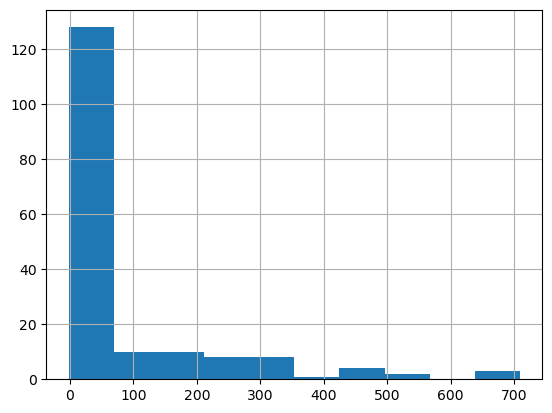

In [21]:
iot_df.select_dtypes(exclude = ['object', 'category', 'datetime64[ns]']).skew(skipna = True, axis = 0).hist()

In [22]:
# Distribution transformation

standard_scale = False

def boxcox_transform(df, skew_threshold = 3, filter_col = None, filter_val = None, method = 'yeo-johnson'):
    
    transformed_df = df.copy()
    non_var_cols = []
    transformers = {}

    for col in df.select_dtypes(include=[np.number]).columns:

        with warnings.catch_warnings():
            warnings.simplefilter('error', RuntimeWarning)
            skewness = df[col].skew()

        if filter_col is None:
            col_data = df[col]
            col_data_train = df[col]
        else:
            col_data = df[col]
            col_data_train = df.loc[df[filter_col] == filter_val, col]

        if skewness > skew_threshold and (col_data >= 0).all():
            try:
                if (col_data == 0).any() and method != 'yeo-johnson':
                    col_data += 1
                    col_data_train += 1

                with warnings.catch_warnings():
                    warnings.simplefilter('ignore', UserWarning)
                    pt = PowerTransformer(method = method, standardize = False)
                    pt.fit(col_data_train.values.reshape(-1, 1))
                    transformed_values = pt.transform(col_data.values.reshape(-1, 1)).flatten()

                if pd.api.types.is_integer_dtype(col_data):
                    transformed_df[col] = np.ceil(transformed_values).astype('int64')
                else:
                    transformed_df[col] = transformed_values

                transformers[col] = pt
                
            except ValueError as e:
                print(f"Box-Cox failed for column '{col}': {e}")
                non_var_cols.append(col)
        else:
            
            transformers[col] = None

    return transformed_df, transformers, non_var_cols

# Distribution transformation and standard scaling

iot_df, dist_transformers, non_var_cols = boxcox_transform(iot_df, skew_threshold = 3,
                                                               filter_col = 'Traffic_type', filter_val = 'Benign', method = 'yeo-johnson')

scaler = StandardScaler() if standard_scale else MinMaxScaler(feature_range = (0, 1), clip = False)
scaling_cols = iot_df.select_dtypes(include=[np.number]).columns.difference(non_var_cols)
scaler.fit(iot_df.loc[iot_df['Traffic_type'] == 'Benign', scaling_cols])
iot_df[scaling_cols] = scaler.transform(iot_df.loc[:, scaling_cols])

iot_df = iot_df.copy()

# Label encoding

labelEncoder = LabelEncoder()
onehotEncoder = OneHotEncoder(drop = ['tcp', '-']).fit(iot_df[['proto', 'service']])
iot_df['Attack_type_l'] = labelEncoder.fit_transform(iot_df['Attack_type'])
iot_df[onehotEncoder.get_feature_names_out()] = onehotEncoder.transform(iot_df[['proto', 'service']]).toarray()
iot_df[iot_df.loc[:, 'Attack_type_l':].columns] = iot_df[iot_df.loc[:, 'Attack_type_l':].columns].astype('int64')
iot_df['ID'] = iot_df['ID'] + '-' + iot_df['Attack_type_l'].astype('str') + iot_df.index.astype('str')

iot_df = iot_df.copy()


In [ ]:
n_components = 3

traffic_mix = {
    'Benign' : (['BenignTraffic.pcap_Flow', 'Thing_Speak', 'Wipro_bulb', 'MQTT_Publish'], 'Dark2'),
    'Scan 1' : (['BenignTraffic.pcap_Flow', 'NMAP_FIN_SCAN', 'NMAP_UDP_SCAN', 'NMAP_XMAS_TREE_SCAN',
                     'NMAP_OS_DETECTION', 'NMAP_TCP_scan'], 'Purples'),
    'DDoS 1' : (['BenignTraffic.pcap_Flow', 'DOS_SYN_Hping', 'ARP_poisioning', 'DDOS_Slowloris', 'Metasploit_Brute_Force_SSH'], 'Blues'),
    'DDoS 2' : (['BenignTraffic.pcap_Flow', 'DDoS-ACK_Fragmentation.pcap_Flow', 'DDoS-ICMP_Flood.pcap_Flow',
                    'DDoS-ICMP_Fragmentation.pcap_Flow', 'DDoS-HTTP_Flood-.pcap_Flow'], 'Reds'),
    'DoS 2' : (['BenignTraffic.pcap_Flow', 'DoS-HTTP_Flood.pcap_Flow', 'DoS-SYN_Flood.pcap_Flow', 'DoS-UDP_Flood.pcap_Flow',
                   'Mirai-greeth_flood.pcap_Flow', 'DictionaryBruteForce.pcap_Flow'], 'spring'),
    'Other 2' : (['BenignTraffic.pcap_Flow', 'MITM-ArpSpoofing.pcap_Flow', 'VulnerabilityScan.pcap_Flow', 'DNS_Spoofing.pcap_Flow ',
                     'SqlInjection.pcap_Flow', 'XSS.pcap_Flow', 'Uploading_Attack.pcap_Flow'], 'cool')}

for traffic_vis in traffic_mix.keys():

    traffic_list = traffic_mix[traffic_vis][0]
    valid_cols = iot_df.select_dtypes(include = [np.number]).columns \
                    .difference(['Attack_type_l'] + [col for col in iot_df.columns if col.startswith('service_')])
    
    normal_iot_df = iot_df.loc[iot_df['Traffic_type'] == 'Benign', valid_cols]
    
    vis_iot_df = \
        iot_df.groupby('Attack_type', group_keys = False, observed = True) \
            .apply(lambda x: x.assign(Attack_type = x.name).sample(3000 if x.name not in \
                ['BenignTraffic.pcap_Flow'] else int(x.shape[0] * 0.05), replace = True), include_groups = False)
    
    vis_iot_df = vis_iot_df.loc[vis_iot_df['Attack_type'].isin(traffic_list), valid_cols]
    Y_class = iot_df.loc[vis_iot_df.index, 'Attack_type']
    
    # Apply PCA (3 principal components)
    pca = PCA(n_components = n_components)
    pca.fit(normal_iot_df)
    X_pca = pca.fit_transform(vis_iot_df)
    
    print('PCA completed!')
    
    # Apply t-SNE
    tsne = TSNE(n_components = n_components, perplexity = 30, random_state = 42)
    X_tsne = tsne.fit_transform(vis_iot_df)
    
    print('t-SNE completed!')
    
    # # Apply UMAP
    # umap_reduce = umap.UMAP(n_components = n_components, random_state = 42)
    # X_umap = umap_reduce.fit_transform(vis_iot_df)
    
    # print('UMAP completed!')
    
    # # Apply Isomap
    # isomap = Isomap(n_components = n_components, n_neighbors = 30)
    # X_isomap = isomap.fit_transform(vis_iot_df)
    
    # print('ISOMAP completed!')
    
    # # Apply Locally Linear Embedding (LLE)
    # lle = LocallyLinearEmbedding(n_components = n_components, n_neighbors = 60, method = 'modified')
    # X_lle = lle.fit_transform(vis_iot_df)
    
    # print('LLE completed!')
    
    # Apply LDA 
    lda = LinearDiscriminantAnalysis(n_components = n_components)
    X_lda = lda.fit_transform(vis_iot_df, Y_class)
    
    print('LDA completed!')
    
    # Plot the results
    fig = plt.figure(figsize = (20, 12), dpi = 400)
    
    # Assign unique colors to each class
    
    classes = np.unique(Y_class)
    col_classes = classes[classes != 'BenignTraffic.pcap_Flow']
    colors = plt.get_cmap(traffic_mix[traffic_vis][1], len(classes))
    class_to_color = {cls: colors(i + 1) for i, cls in enumerate(col_classes)}
    class_to_color.update({'BenignTraffic.pcap_Flow' : plt.get_cmap('Dark2', 1)(1)})
    
    # --- PCA ---
    ax1 = fig.add_subplot(131, projection = '3d')
    
    for cls in classes:
        
        if cls == 'BenignTraffic.pcap_Flow':
            alpha = 0.2
            size = 10
        else:
            alpha = 0.7
            size = 30
            
        idx = (Y_class.reset_index(drop = True) == cls)
        ax1.scatter(X_pca[idx, 0], X_pca[idx, 1], X_pca[idx, 2], alpha = alpha, s = size, label = str(cls), color = class_to_color[cls])
    
    ax1.set_title('PCA (3D)')
    ax1.set_xlabel('Component 1')
    ax1.set_ylabel('Component 2')
    ax1.set_zlabel('Component 3')
    
    # --- t-SNE ---
    ax2 = fig.add_subplot(132, projection = '3d')
    
    for cls in classes:
        
        if cls == 'BenignTraffic.pcap_Flow':
            alpha = 0.2
            size = 10
        else:
            alpha = 0.7
            size = 30
          
        idx = (Y_class.reset_index(drop = True) == cls)
        ax2.scatter(X_tsne[idx, 0], X_tsne[idx, 1], X_tsne[idx, 2], alpha = alpha, s = size, label = str(cls), color = class_to_color[cls])
    
    ax2.set_title('t-SNE (3D)')
    ax2.set_xlabel('Component 1')
    ax2.set_ylabel('Component 2')
    ax2.set_zlabel('Component 3')
    
    # # --- UMAP ---
    # ax3 = fig.add_subplot(233, projection = '3d')
    
    # for cls in classes:
        
    #     if cls == 'BenignTraffic.pcap_Flow':
    #         alpha = 0.3
    #         size = 5
    #     else:
    #         alpha = 0.7
    #         size = 30
          
    #     idx = (Y_class.reset_index(drop = True) == cls)
    #     ax3.scatter(X_umap[idx, 0], X_umap[idx, 1], X_umap[idx, 2], alpha = alpha, s = size, label = str(cls), color = class_to_color[cls])
    
    # ax3.set_title('UMAP (3D)')
    # ax3.set_xlabel('Component 1')
    # ax3.set_ylabel('Component 2')
    # ax3.set_zlabel('Component 3')
    
    # # --- ISOMAP ---
    # ax4 = fig.add_subplot(234, projection = '3d')
    
    # for cls in classes:
        
    #     if cls == 'BenignTraffic.pcap_Flow':
    #         alpha = 0.3
    #         size = 5
    #     else:
    #         alpha = 0.7
    #         size = 30
          
    #     idx = (Y_class.reset_index(drop = True) == cls)
    #     ax4.scatter(X_isomap[idx, 0], X_isomap[idx, 1], X_isomap[idx, 2], alpha = alpha, s = size, label = str(cls), color = class_to_color[cls])
    
    # ax4.set_title('ISOMAP (3D)')
    # ax4.set_xlabel('Component 1')
    # ax4.set_ylabel('Component 2')
    # ax4.set_zlabel('Component 3')
    
    # # --- LLE ---
    # ax5 = fig.add_subplot(235, projection = '3d')
    
    # for cls in classes:
        
    #     if cls == 'BenignTraffic.pcap_Flow':
    #         alpha = 0.3
    #         size = 5
    #     else:
    #         alpha = 0.7
    #         size = 30
          
    #     idx = (Y_class.reset_index(drop = True) == cls)
    #     ax5.scatter(X_lle[idx, 0], X_lle[idx, 1], X_lle[idx, 2], alpha = alpha, s = size, label = str(cls), color = class_to_color[cls])
    
    # ax5.set_title('LLE (3D)')
    # ax5.set_xlabel('Component 1')
    # ax5.set_ylabel('Component 2')
    # ax5.set_zlabel('Component 3')
    
    # --- LDA (3D) ---
    ax6 = fig.add_subplot(133, projection = '3d')
    
    for cls in classes:
        
        if cls == 'BenignTraffic.pcap_Flow':
            alpha = 0.2
            size = 10
        else:
            alpha = 0.7
            size = 30
          
        idx = (Y_class.reset_index(drop = True) == cls)
        ax6.scatter(X_lda[idx, 0], X_lda[idx, 1], X_lda[idx, 2], alpha = alpha, s = size, label = str(cls), color = class_to_color[cls])
    
    ax6.set_title('LDA (3D)')
    ax6.set_xlabel('Component 1')
    ax6.set_ylabel('Component 2')
    ax6.set_zlabel('Component 3')
    
    # Shared legend
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc = 'lower center', ncol = 2, fontsize = 'large')
    
    fig.tight_layout(rect = [0, 0.05, 1, 1])
    fig.savefig('dimensionality_reduction_{}.png'.format(traffic_vis), dpi = 400)
    plt.show()


In [3]:
top_n = 10

# Plot data points
fig = plt.figure(figsize = (10, 8), dpi = 400)

valid_cols = iot_df.select_dtypes(include = [np.number]).columns \
                .difference(['Attack_type_l'] + [col for col in iot_df.columns if col.startswith('service_')])

normal_iot_df = iot_df.loc[iot_df['Traffic_type'] == 'Benign', valid_cols]
Y_class = iot_df.loc[normal_iot_df.index, 'Attack_type']

# Apply PCA (3 principal components)
pca = PCA(n_components = n_components)
pca.fit(normal_iot_df)
X_pca = pca.fit_transform(normal_iot_df)

print('PCA completed!')

loadings = pca.components_.T
classes = np.unique(Y_class)
colors = plt.get_cmap('Dark2', len(classes))
class_to_color = {cls: colors(i) for i, cls in enumerate(classes)}

for cls in classes:

    if cls == 'BenignTraffic.pcap_Flow':
        alpha = 0.3
        size = 5
    else:
        alpha = 0.7
        size = 30
    
    idx = (Y_class.reset_index(drop = True) == cls)

    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], alpha = alpha, s = size, label = cls, color = class_to_color[cls])
    sns.kdeplot(x = X_pca[idx, 0], y = X_pca[idx, 1], alpha = 0.7, label = cls, color = class_to_color[cls])

# Plot feature vectors (loadings)

feature_names = valid_cols
components = pca.components_
feature_importance = np.linalg.norm(components, axis = 0)
top_features_idx = np.argsort(feature_importance)[::-1]
top_features = feature_names[top_features_idx]
    
for feature in normal_iot_df[top_features[:top_n]].columns:
    i = feature_names.get_loc(feature)
    plt.arrow(0, 0, loadings[i, 0] * 25, loadings[i, 1] * 25, color = 'red', alpha = 0.7, width = 0.02)
    plt.text(loadings[i, 0] * 25.5, loadings[i, 1] * 25.5 + np.random.normal(loc = 0, scale = 0.2), feature, color = 'black', fontsize = 7)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.title('PCA Biplot', loc = 'left')
plt.axhline(0, color = 'grey', lw = 1)
plt.axvline(0, color = 'grey', lw = 1)
plt.grid()
plt.legend()

fig.savefig('pca_bi_plot.png', dpi = 400)

plt.show()

In [4]:
top_n = 10

# Prepare loadings and colors
loadings = pca.components_.T
classes = np.unique(Y_class)
colors = plt.get_cmap('Dark2', len(classes))
class_to_color = {cls: colors(i) for i, cls in enumerate(classes)}

# Start 3D plot
fig = plt.figure(figsize = (12, 10), dpi = 400)
ax = fig.add_subplot(111, projection='3d')

# Plot scatter points
for cls in classes:
    if cls == 'BenignTraffic.pcap_Flow':
        alpha = 0.3
        size = 5
    else:
        alpha = 0.7
        size = 30
    idx = (Y_class.reset_index(drop=True) == cls)
    ax.scatter(X_pca[idx, 0], X_pca[idx, 1], X_pca[idx, 2],
               label=cls, color=class_to_color[cls], alpha = alpha, s = size)

# Plot feature vectors (arrows)
feature_names = valid_cols
components = pca.components_
feature_importance = np.linalg.norm(components, axis = 0)
top_features_idx = np.argsort(feature_importance)[::-1]
top_features = feature_names[top_features_idx]

for feature in normal_iot_df[top_features[:top_n]].columns:
    i = feature_names.get_loc(feature)
    ax.quiver(0, 0, 0, 
              loadings[i, 0] * 100, loadings[i, 1] * 100, loadings[i, 2] * 100, 
              color = 'red', alpha = 0.8, arrow_length_ratio = 0.02)
    ax.text(loadings[i, 0] * 103, loadings[i, 1] * 203, loadings[i, 2] * 103,
            feature, color = 'black', fontsize=8)

# Labels and title
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.2f}%)')
ax.set_title('3D PCA Biplot', loc='left')
ax.legend()

ax.view_init(elev = 30, azim = 300)

fig.savefig('pca_biplot_3d.png', dpi = 400)
plt.show()


In [1]:
# Parallel coordinate plot

def plot_parallel_coordinates_top_features(x, class_column_name, n_features, min_bins, max_bins,
                                               factor = 10, max_points = 3000, max_points_ref = 15000,
                                                   ref_class = 'BenignTraffic.pcap_Flow', traffic_list = ['BenignTraffic.pcap_Flow'],
                                                       cmap = 'Dark2', name = 'Normal'):

    def compute_dynamic_bins(feature_matrix, min_bins, max_bins, factor):

        n_unique = np.array([len(np.unique(feature_matrix[:, i])) for i in range(feature_matrix.shape[1])])
    
        bins = np.clip(n_unique // factor, min_bins, max_bins)
        bins = np.where(n_unique < min_bins, n_unique, bins)
        bins[bins < 2] = 2
        
        return bins

    valid_cols = x.select_dtypes(include = [np.number]).columns \
                    .difference(['Attack_type_l'] + [col for col in x.columns if col.startswith('service_')])

    X_filtered = x.loc[x[class_column_name].isin(traffic_list), :]
    X_numeric = x.loc[x[class_column_name].isin(traffic_list), valid_cols]
    y = x.loc[X_numeric.index, class_column_name]

    # Discretize numeric features for mutual information calculation

    n_bins = compute_dynamic_bins(X_numeric.values, min_bins = min_bins, max_bins = max_bins, factor = factor)

    with warnings.catch_warnings():
        
        warnings.filterwarnings('ignore', category = UserWarning, module = 'sklearn')
        
        discretizer = KBinsDiscretizer(n_bins = n_bins, encode = 'ordinal', strategy = 'quantile')
        X_discrete = discretizer.fit_transform(X_numeric)

    # Compute mutual information
    mi_scores = mutual_info_classif(X_discrete, y, discrete_features = True)

    # Select top n_features
    top_indices = np.argsort(mi_scores)[-n_features:]
    top_features = X_numeric.columns[top_indices]

    print('Top selected features based on MI:', list(top_features))

    # Sample data for plotting
    
    plot_df = \
        X_filtered.groupby(class_column_name, group_keys = False, observed = True) \
            .apply(lambda x: x.assign(Attack_type = x.name).sample(max_points if x.name not in \
                [ref_class] else max_points_ref, replace = True), include_groups = False)

    plot_df = plot_df[top_features]
    plot_df_y = X_filtered.loc[plot_df.index, class_column_name].astype('str')

    # Plot using Plotly

    y_numeric = plot_df_y.astype('category')
    category_codes = y_numeric.cat.codes
    category_labels = y_numeric.cat.categories.tolist()

    # Create a mapping from class to color

    unique_classes = y_numeric.cat.categories.tolist()
    palette = plt.get_cmap(cmap, len(unique_classes))
    palette = [palette(i) for i in range(len(unique_classes))]
    palette = [f'rgba({int(r*255)}, {int(g*255)}, {int(b*255)}, {a})' for r, g, b, a in palette]
    color_map = {}

    # Assign colors, with ref_class = grey
    for i, cls in enumerate(unique_classes):
        if cls == ref_class:
            color_map[cls] = 'lightgrey'
        else:
            color_map[cls] = palette[i]

    sort_order = plot_df_y.apply(lambda x: 1 if x == ref_class else 0)
    sorted_df = plot_df.assign(_class = plot_df_y, _color = category_codes, _sort = sort_order)
    sorted_df = sorted_df.sort_values(by = '_sort')
    sorted_df = sorted_df.drop(columns = '_sort')
    
    fig = px.parallel_coordinates(
        sorted_df,
        color = '_color',
        labels = {col : col for col in plot_df.columns},
        color_continuous_scale = [color_map[cls] for cls in unique_classes],
        range_color =[category_codes.min(), category_codes.max()],
        dimensions = top_features.tolist())

    fig.update_layout(
        title = '',
        plot_bgcolor = 'white',
        margin = dict(l = 80, r = 150, t = 100, b = 80),
        height = 700,
        width = 1600,
        coloraxis_colorbar = dict(
            title = 'Traffic',
            tickvals = list(range(len(category_labels))),
            ticktext = category_labels))
    
    pio.write_html(fig, 'parallel_coordinates_plot_{}.html'.format(name))

    fig.show()

traffic_mix = {
    'Benign' : (['BenignTraffic.pcap_Flow', 'Thing_Speak', 'Wipro_bulb', 'MQTT_Publish'], 'Dark2'),
    'Scan 1' : (['BenignTraffic.pcap_Flow', 'NMAP_FIN_SCAN', 'NMAP_UDP_SCAN', 'NMAP_XMAS_TREE_SCAN',
                     'NMAP_OS_DETECTION', 'NMAP_TCP_scan'], 'Purples'),
    'DDoS 1' : (['BenignTraffic.pcap_Flow', 'DOS_SYN_Hping', 'ARP_poisioning', 'DDOS_Slowloris', 'Metasploit_Brute_Force_SSH'], 'Blues'),
    'DDoS 2' : (['BenignTraffic.pcap_Flow', 'DDoS-ACK_Fragmentation.pcap_Flow', 'DDoS-ICMP_Flood.pcap_Flow',
                    'DDoS-ICMP_Fragmentation.pcap_Flow', 'DDoS-HTTP_Flood-.pcap_Flow'], 'Reds'),
    'DoS 2' : (['BenignTraffic.pcap_Flow', 'DoS-HTTP_Flood.pcap_Flow', 'DoS-SYN_Flood.pcap_Flow', 'DoS-UDP_Flood.pcap_Flow',
                   'Mirai-greeth_flood.pcap_Flow', 'DictionaryBruteForce.pcap_Flow'], 'spring'),
    'Other 2' : (['BenignTraffic.pcap_Flow', 'MITM-ArpSpoofing.pcap_Flow', 'VulnerabilityScan.pcap_Flow', 'DNS_Spoofing.pcap_Flow ',
                     'SqlInjection.pcap_Flow', 'XSS.pcap_Flow', 'Uploading_Attack.pcap_Flow'], 'cool')}

for traffic_vis in traffic_mix.keys():

    plot_parallel_coordinates_top_features(iot_df, class_column_name = 'Attack_type', n_features = 10,
                                               min_bins = 2, max_bins = 10, factor = 5, max_points = 3000, max_points_ref = 15000,
                                                   ref_class = 'BenignTraffic.pcap_Flow', traffic_list = traffic_mix[traffic_vis][0],
                                                       cmap = traffic_mix[traffic_vis][1], name = traffic_vis)

    print(traffic_vis, 'completed!')


In [2]:
# Sample Data

max_points = 500
max_points_ref = int((len(iot_df['Attack_type'].unique().tolist()) * max_points) / 2)

ref_class = 'BenignTraffic.pcap_Flow'
multiplier = 10

# Select valid columns (numeric columns excluding some specific ones)
valid_cols = iot_df.select_dtypes(include=[np.number]).columns \
    .difference(['Attack_type_l'] + [col for col in iot_df.columns if col.startswith('service_')])

# Create plot_df by sampling data
plot_df = iot_df.groupby('Attack_type', group_keys=False, observed=True) \
    .apply(lambda x: x.assign(Attack_type=x.name).sample(
        max_points if x.name not in [ref_class] else max_points_ref, 
        replace=True if x.shape[0] < max_points else False), 
           include_groups=False)

plot_df = plot_df.loc[:, valid_cols]
Y_class = iot_df.loc[plot_df.index, 'Attack_type']

# Encode class labels
le = LabelEncoder()
Y_class_encoded = le.fit_transform(Y_class)
label_map = dict(zip(le.transform(le.classes_), le.classes_))

# Initialize KeplerMapper
mapper = km.KeplerMapper(verbose = 1)

# Project data using KernelPCA
projected = mapper.fit_transform(plot_df, projection = KernelPCA(n_components = 6, kernel = 'rbf', gamma = 0.1))

# Create a graph using DBSCAN clustering
graph = mapper.map(projected,
                   plot_df,
                   clusterer = DBSCAN(eps = 2.5, min_samples = 30),
                   cover = km.Cover(n_cubes = 3, perc_overlap = 0.3))

# Construct colourscale

traffic_mix = {
    'Benign' : (['BenignTraffic.pcap_Flow', 'Thing_Speak', 'Wipro_bulb', 'MQTT_Publish'], 'Greens'),
    'Scan 1' : (['BenignTraffic.pcap_Flow', 'NMAP_FIN_SCAN', 'NMAP_UDP_SCAN', 'NMAP_XMAS_TREE_SCAN',
                     'NMAP_OS_DETECTION', 'NMAP_TCP_scan'], 'Purples'),
    'DDoS 1' : (['BenignTraffic.pcap_Flow', 'DOS_SYN_Hping', 'ARP_poisioning', 'DDOS_Slowloris', 'Metasploit_Brute_Force_SSH'], 'Blues'),
    'DDoS 2' : (['BenignTraffic.pcap_Flow', 'DDoS-ACK_Fragmentation.pcap_Flow', 'DDoS-ICMP_Flood.pcap_Flow',
                    'DDoS-ICMP_Fragmentation.pcap_Flow', 'DDoS-HTTP_Flood-.pcap_Flow'], 'Reds'),
    'DoS 2' : (['BenignTraffic.pcap_Flow', 'DoS-HTTP_Flood.pcap_Flow', 'DoS-SYN_Flood.pcap_Flow', 'DoS-UDP_Flood.pcap_Flow',
                   'Mirai-greeth_flood.pcap_Flow', 'DictionaryBruteForce.pcap_Flow'], 'Greys'),
    'Other 2' : (['BenignTraffic.pcap_Flow', 'MITM-ArpSpoofing.pcap_Flow', 'VulnerabilityScan.pcap_Flow', 'DNS_Spoofing.pcap_Flow ',
                     'SqlInjection.pcap_Flow', 'XSS.pcap_Flow', 'Uploading_Attack.pcap_Flow'], 'Oranges')}

class_color_map = {}
for group, (class_list, cmap_name) in traffic_mix.items():

    n_classes = len(class_list) + 1
    
    cmap = plt.get_cmap(cmap_name, n_classes)

    for i, cls in enumerate(class_list):
        
        if (group != 'Benign' and cls != 'BenignTraffic.pcap_Flow') or group == 'Benign':

            rgba = cmap(i + 1)
            rgb = tuple(int(255 * c) for c in rgba[:3])
            class_color_map[cls] = f'rgb{rgb}'

sorted_classes = sorted(class_color_map.keys())
n = len(sorted_classes)

colorscale = []
for i, cls in enumerate(sorted_classes):
    percent = i / (n - 1) if n > 1 else 0.0
    colorscale.append([percent, class_color_map[cls]])

# Visualization parameters

title = ''
color_values = Y_class_encoded  # Color nodes by class/target
graph_layout = 'kk'  # Kamada-Kawai layout for the graph
node_color_function = 'median'  # Color nodes based on the mean class of their members

# Plotting the graph using KeplerMapper's plotlyviz function
fig = km.plotlyviz.plotlyviz(
    scomplex = graph,
    title = title,
    colorscale = colorscale,
    graph_layout = graph_layout,
    color_values = color_values,
    node_color_function = node_color_function,
    dashboard = False,
    graph_data = False,
    factor_size = 2,
    edge_linewidth = 0.5,
    node_linecolor = 'rgb(200,200,200)',
    width = 1600,
    height = 1000,
    bgcolor = 'rgba(240, 240, 240, 0.95)',
    filename = None)

pio.write_html(fig, 'topological_graph.html'.format(name))

fig.show()


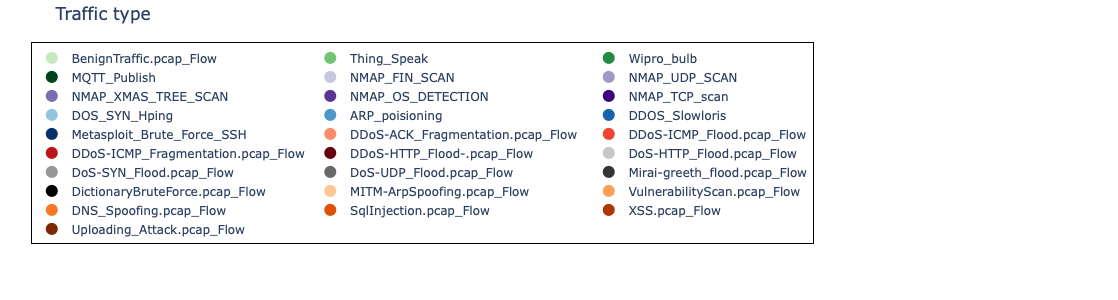

In [80]:
# Generate invisible traces for legend only

fig_l = go.Figure()

for class_name, color in class_color_map.items():
    fig_l.add_trace(go.Scatter(
        x = [None],
        y = [None],
        mode = 'markers',
        marker = dict(size = 12, color = color),
        name = class_name,
        showlegend = True))

fig_l.update_layout(
    title = 'Traffic type',
    showlegend = True,
    legend = dict(
        orientation = 'h',
        x = 0.01,
        y = 0.99,
        font = dict(size = 12),
        bordercolor = "Black",
        borderwidth = 1),
    xaxis = dict(visible = False),
    yaxis=dict(visible = False),
    plot_bgcolor = 'white',
    width = 1600,
    height = 300,
    margin = dict(l = 20, r = 20, t = 40, b = 20))

# Save as HTML or image
fig_l.write_html('topological_graph_legend.html')

fig_l.show()


In [147]:
(iot_df.loc[((iot_df['Traffic_type'] == 'Benign') & (iot_df['Attack_type'].str.endswith('.pcap_Flow') == False)), 'id.orig_p'].value_counts() / \
    iot_df.loc[((iot_df['Traffic_type'] == 'Benign') & (iot_df['Attack_type'].str.endswith('.pcap_Flow') == False)), :] \
         .shape[0]).iloc[:5].sum()


0.013112656912129208

In [138]:
iot_df.loc[((iot_df['Traffic_type'] != 'Benign') & (iot_df['Attack_type'].str.endswith('.pcap_Flow') == False)), 'id.resp_p'].nunique()

1801

In [151]:
(iot_df.assign(pair = iot_df['ip_src'] + iot_df['ip_dst']) \
     .loc[((iot_df['Traffic_type'] != 'Benign') & (iot_df['Attack_type'].str.endswith('.pcap_Flow') == True)), 'pair'].value_counts() / \
        iot_df.loc[((iot_df['Traffic_type'] != 'Benign') & (iot_df['Attack_type'].str.endswith('.pcap_Flow') == True)), :] \
            .shape[0]).iloc[:5].sum()

0.15768577592142102

In [157]:
(iot_df.assign(pair = iot_df['id.orig_p'] + iot_df['id.resp_p'])) \
     .loc[((iot_df['Traffic_type'] != 'Benign') & (iot_df['Attack_type'].str.endswith('.pcap_Flow') == False)), 'pair'].nunique()

33943